<a href="https://colab.research.google.com/github/asheshd/DES-Project-xG-PySpark-ML/blob/main/Expected_Goals_Analysis_with_PySpark_DES_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DA 231o Data Engineering at Scale Project



# Expected Goals Model & Player Analysis

### Import Libraries

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 30 kB/s 
     |████████████████████████████████| 199 kB 51.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=b2e43813abbddd7ee75e55576e361845f139e63858ecb9763fecdb8db4fd016e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import pyspark
pyspark.__version__

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, regexp_replace, when, col

# Load input Dataset with Goals

In [3]:
# Mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read the csv file for visualization. We do not use this data anywhere in our model

data = pd.read_csv('/content/drive/Shareddrives/DES_Project/events.csv')

In [5]:
print(len(data))
print(data.is_goal.sum())
print(len(data.columns)-1)

941009
24446
21


In [6]:
data.columns

Index(['id_odsp', 'id_event', 'sort_order', 'time', 'text', 'event_type',
       'event_type2', 'side', 'event_team', 'opponent', 'player', 'player2',
       'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
       'location', 'bodypart', 'assist_method', 'situation', 'fast_break'],
      dtype='object')

In [7]:
# Create spark session

spark = SparkSession \
    .builder \
    .appName('xG Project Solution') \
    .getOrCreate()
  
spark

In [8]:
# Load the events and the info as spark sql dataframes

eventsDF = spark.read.option("header", True).option("inferSchema", True).option("nullable", 'NA').csv('/content/drive/Shareddrives/DES_Project/events.csv')
infoDF = spark.read.option("header", True).option("inferSchema", True).option("nullable", 'NA').csv('/content/drive/Shareddrives/DES_Project/ginf.csv')

In [9]:
# Print Schema

eventsDF.printSchema()

infoDF.printSchema()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type2: string (nullable = true)
 |-- side: integer (nullable = true)
 |-- event_team: string (nullable = true)
 |-- opponent: string (nullable = true)
 |-- player: string (nullable = true)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: string (nullable = true)
 |-- shot_outcome: string (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- bodypart: string (nullable = true)
 |-- assist_method: integer (nullable = true)
 |-- situation: string (nullable = true)
 |-- fast_break: integer (nullable = true)

root
 |-- id_odsp: string (nullable = true)
 |-- link_odsp: string (nullable = true)
 |-- adv_stat

In [10]:
# Verify if the data loaded is correct and in the proper format

eventsDF.show(10)
type(eventsDF)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|             player|         player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+
|UFot0hit/| UFot0hit1|         1|   2|Attempt missed. M...|         1|         12|   2|       Hamburg SV|Borussia Dortmund|      mladen petric|     gokhan tore|       NA|        NA|         6|       

pyspark.sql.dataframe.DataFrame

In [11]:
# Join id_odsp, country, date columns from infoDF on id_odsp

eventsDF = eventsDF.join(infoDF[['id_odsp', 'country', 'date']], on='id_odsp', how='left')
eventsDF.printSchema()
eventsDF.show(10)
eventsDF.count()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type2: string (nullable = true)
 |-- side: integer (nullable = true)
 |-- event_team: string (nullable = true)
 |-- opponent: string (nullable = true)
 |-- player: string (nullable = true)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: string (nullable = true)
 |-- shot_outcome: string (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- bodypart: string (nullable = true)
 |-- assist_method: integer (nullable = true)
 |-- situation: string (nullable = true)
 |-- fast_break: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- date: timestamp (nullable = true)

+---------+---------

941009

In [12]:
# Extract year from the timestamp and append the column

extract_year = lambda x: x.strftime("%Y")
extract_year_udf = udf(extract_year)
eventsDF = eventsDF.withColumn("year", extract_year_udf("date"))
eventsDF.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|             player|         player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|UFot0hit/| UFot0hit1|         1|   2|Attempt missed. M...|         1|         12|   2|       Hambur

In [13]:
eventsDF.filter(eventsDF.event_type==1).filter(eventsDF.player != '').count()

229134

In [14]:
# Create shotsDF dataframe by filtering event type == 1 and non-empty player

shotsDF = eventsDF.filter(eventsDF.event_type==1).filter(eventsDF.player != '').filter(eventsDF.player2 != '').filter(eventsDF.country != '')
shotsDF = shotsDF.withColumn("player", udf(lambda x: x.title())("player"))
shotsDF = shotsDF.withColumn("player2", udf(lambda x: x.title())("player2"))
shotsDF = shotsDF.withColumn("country", udf(lambda x: x.title())("country"))
shotsDF.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|           player|           player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|UFot0hit/| UFot0hit1|         1|   2|Attempt missed. M...|         1|         12|   2|       Hambur

In [15]:
# Filter the columns which have all the relevant information about the shot and predict if it is a goal or not
# is_goal is the true label. We will not use this in the training

required_cols = ['shot_place', 'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation']

# Create dataDF dataframe with all the input columns
dataDF = shotsDF

# Create string indexer list
indexer = []

# Convert each column into integer type using string indexer without losing any features
for column in required_cols:
  temp = StringIndexer(inputCol=column, outputCol=column+"_index")
  indexer.append(temp)

# Pipeline
pipeline = Pipeline(stages=indexer)
dataDF = pipeline.fit(dataDF).transform(dataDF)

dataDF.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|           player|           player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+----

# Expected Goals with PySpark Machine Learning

In [16]:
required_features = list(dataDF.columns[-6:]) # remove 'is_goal' because it is the label

assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(dataDF)

transformed_data.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+--------------------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|           player|           player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|            features|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+-------------

In [17]:
# Split the data into training and testing data

(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])

print("Total Data", transformed_data.count())
print("Total Training Data", training_data.count())
print("Total Test Data", test_data.count())

print("\nTraining Dataset")
training_data.show(5)

Total Data 229131
Total Training Data 183297
Total Test Data 45834

Training Dataset
+---------+-----------+----------+----+--------------------+----------+-----------+----+----------+--------+------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+--------------------+
|  id_odsp|   id_event|sort_order|time|                text|event_type|event_type2|side|event_team|opponent|            player|         player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|            features|
+---------+-----------+----------+----+--------------------+----------+-----------+----+----------+--

# Gradient-Boosted Trees (GBTs) Classifier

In [18]:
gbt = GBTClassifier(labelCol='is_goal', 
                            featuresCol='features',
                            maxDepth=5)

In [19]:
# Another classifier
# from pyspark.ml.classification import DecisionTreeClassifier
# gbt = DecisionTreeClassifier(labelCol='is_goal', 
#                             featuresCol='features',
#                             maxDepth=5)

In [20]:
# Fit the model on training data
model = gbt.fit(training_data)

# Predictions with Test Data

In [21]:
# Predictions with test data
predictions = model.transform(test_data)
predictions.show(5)

+---------+-----------+----------+----+--------------------+----------+-----------+----+----------+--------+---------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+--------------------+--------------------+--------------------+----------+
|  id_odsp|   id_event|sort_order|time|                text|event_type|event_type2|side|event_team|opponent|         player|         player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|            features|       rawPrediction|         probability|prediction|
+---------+-----------+----------+----+--------------------+----------+-----------+---

# Evaluate our model

In [22]:
# Evaluate our model
evaluator = MulticlassClassificationEvaluator(
    labelCol='is_goal', 
    predictionCol='prediction', 
    metricName='accuracy')

# Calculate Test Accuracy

In [23]:
accuracy = evaluator.evaluate(predictions)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.9404154121394598


In [24]:
from pyspark.ml.evaluation import RegressionEvaluator

regEvaluator = RegressionEvaluator(
    labelCol='is_goal', 
    predictionCol='prediction', 
    metricName='rmse')

rmse = regEvaluator.evaluate(predictions)
print('RMSE = ', rmse)

RMSE =  0.24409954498224737


# Player Analysis

In [25]:
# Predict the expected goal on all the data (training + test)

pred = model.transform(transformed_data)
pred.show()
pred.count()

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+------------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+--------------------+--------------------+--------------------+----------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|            player|           player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|            features|       rawPrediction|         probability|prediction|
+---------+----------+----------+----+--------

229131

In [26]:
# Create a new dataframe with selected columns for player analysis

players = pred.select('player', 'is_goal', 'prediction')
players.count()

229131

In [27]:
# Count the number of actual goals and expected goals per player

metrics = players.groupBy('player').sum()
metrics = metrics.withColumnRenamed('sum(is_goal)', 'true_goals').withColumnRenamed('sum(prediction)', 'expected_goals')

# Calculate the difference between the expected goals and the true goals
# Absolute difference indicates the number of goals made on top of the expected goals
metrics = metrics.withColumn('difference', metrics.expected_goals - metrics.true_goals)

# Sort by the least difference (Expected - True)
result = metrics.sort('difference')

# Best Finishers with most goals on top of expected
# Top 10 finishers
result.show(10)

+------------------+----------+--------------+----------+
|            player|true_goals|expected_goals|difference|
+------------------+----------+--------------+----------+
| Cristiano Ronaldo|       198|         168.0|     -30.0|
|   Gonzalo Higuain|       118|          95.0|     -23.0|
|        Marco Reus|        65|          44.0|     -21.0|
|Robert Lewandowski|       124|         105.0|     -19.0|
|      Lionel Messi|       205|         186.0|     -19.0|
|       Gareth Bale|        50|          31.0|     -19.0|
|       Luis Muriel|        38|          20.0|     -18.0|
| Antoine Griezmann|        80|          63.0|     -17.0|
|       Eden Hazard|        62|          45.0|     -17.0|
|       Luis Suarez|        96|          80.0|     -16.0|
+------------------+----------+--------------+----------+
only showing top 10 rows



In [28]:
# Messi is my favourite player. So showing the result below

result.filter(result.player == 'Lionel Messi').show()

+------------+----------+--------------+----------+
|      player|true_goals|expected_goals|difference|
+------------+----------+--------------+----------+
|Lionel Messi|       205|         186.0|     -19.0|
+------------+----------+--------------+----------+



In [29]:
# Sort by ratio between the true goals and the expected goals in descending order
# Best Finishers with highest (true goals / expected goals) ratio
result = result.withColumn('ratio', result['true_goals'] / result['expected_goals'])
result.orderBy(col('ratio').desc()).show(5)

+---------------+----------+--------------+----------+-----+
|         player|true_goals|expected_goals|difference|ratio|
+---------------+----------+--------------+----------+-----+
|   Gokhan Inler|         9|           1.0|      -8.0|  9.0|
| Cristian Tello|        13|           2.0|     -11.0|  6.5|
|   Jordon Mutch|         6|           1.0|      -5.0|  6.0|
|Geoffrey Dernis|         6|           1.0|      -5.0|  6.0|
| Adrian Embarba|         5|           1.0|      -4.0|  5.0|
+---------------+----------+--------------+----------+-----+
only showing top 5 rows



# Correlation between Expected Goals and True Goals is very high

In [30]:
cor = result.stat.corr('true_goals', 'expected_goals')
print("Correlation between Expected Goals and True Goals is", cor)

Correlation between Expected Goals and True Goals is 0.9832102747903231


# Result Plots

In [31]:
graphDF = result.toPandas()
graphDF = graphDF[['player', 'difference', 'true_goals', 'expected_goals', 'ratio']].head(10)
graphDF.head(10)

,player,difference,true_goals,expected_goals,ratio
0,Cristiano Ronaldo,-30.0,198,168.0,1.178571
1,Gonzalo Higuain,-23.0,118,95.0,1.242105
2,Marco Reus,-21.0,65,44.0,1.477273
3,Robert Lewandowski,-19.0,124,105.0,1.180952
4,Gareth Bale,-19.0,50,31.0,1.612903
5,Lionel Messi,-19.0,205,186.0,1.102151
6,Luis Muriel,-18.0,38,20.0,1.900000
7,Eden Hazard,-17.0,62,45.0,1.377778
8,Antoine Griezmann,-17.0,80,63.0,1.269841
9,Karim Benzema,-16.0,85,69.0,1.231884


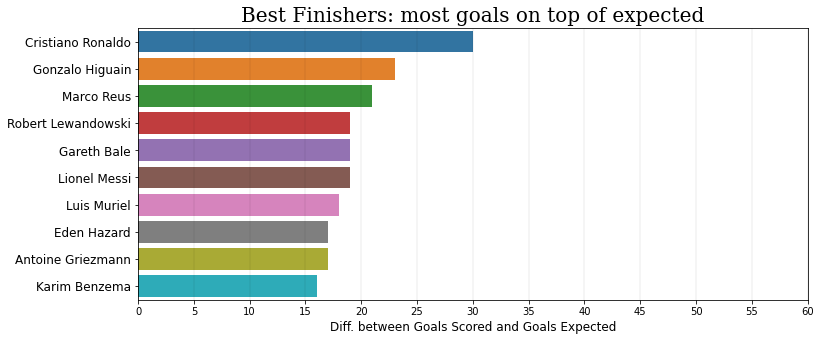

In [32]:
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=abs(graphDF['difference']), y=graphDF['player'])
ax.set_xticks(np.arange(0,65,5))
ax.set_xlabel(xlabel='Diff. between Goals Scored and Goals Expected', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: most goals on top of expected", fontsize=20, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
plt.show()

In [33]:
graphDF = graphDF[graphDF['true_goals']>30].sort_values(['ratio', 'true_goals'], ascending=False).reset_index(drop=True)
graphDF = graphDF[['player', 'ratio', 'true_goals', 'expected_goals', 'difference']].head(10)
graphDF.head(10)

,player,ratio,true_goals,expected_goals,difference
0,Luis Muriel,1.900000,38,20.0,-18.0
1,Gareth Bale,1.612903,50,31.0,-19.0
2,Marco Reus,1.477273,65,44.0,-21.0
3,Eden Hazard,1.377778,62,45.0,-17.0
4,Antoine Griezmann,1.269841,80,63.0,-17.0
5,Gonzalo Higuain,1.242105,118,95.0,-23.0
6,Karim Benzema,1.231884,85,69.0,-16.0
7,Robert Lewandowski,1.180952,124,105.0,-19.0
8,Cristiano Ronaldo,1.178571,198,168.0,-30.0
9,Lionel Messi,1.102151,205,186.0,-19.0


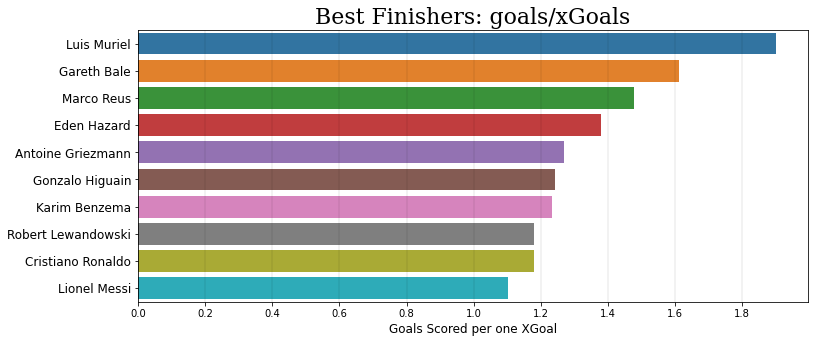

In [34]:
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=graphDF['ratio'], y=graphDF['player'])
ax.set_xticks(np.arange(0,1.9,0.2))
ax.set_xlabel(xlabel='Goals Scored per one XGoal', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: goals/xGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()